# MC REINFORCE

In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('CartPole-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print("State shape:", state_shape)
print("Number of Actions: ",no_of_actions)
print("Sampled Action",env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print("Current_State: ",state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print("Sampled Action2: ", action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print("Next_State: ",next_state)
print("Reward: ",reward)
print("Done: ", done)
print("Info: ", info)
print("----")


State shape: 4
Number of Actions:  2
Sampled Action 1
----
Current_State:  [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
----
Sampled Action2:  0
----
Next_State:  [ 0.01323574 -0.21745604 -0.04686959  0.22950698]
Reward:  1.0
Done:  False
Info:  {}
----


# MC REINFORCE W/O BASELINE

In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import torch
import numpy as np
from collections import deque, namedtuple

from scipy.special import softmax
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
'''BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)'''

class Policy(nn.Module):

    def __init__(self, state_size, action_size, seed=0, num_policy_layers =1,num_policy_layer_units= 64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Policy, self).__init__()
        self.seed = torch.manual_seed(seed)
        activation = nn.LeakyReLU
        self.fc_start = nn.Sequential(*[nn.Linear(state_size, num_policy_layer_units),activation()])
        self.fc_hidden = nn.Sequential(*[nn.Sequential(*[nn.Linear(num_policy_layer_units,num_policy_layer_units),activation()]) for _ in range(num_policy_layers-1)])
        self.fc_end = nn.Linear(num_policy_layer_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        xs = self.fc_start(state)
        x_hidden = self.fc_hidden(xs)
        x_out = self.fc_end(x_hidden)
        return F.softmax(x_out, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)


In [4]:
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=0.99, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break

        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Convert rewards to torch tensor
        rewards = torch.FloatTensor(rewards)

        # Calculate discounted returns
        discounts = torch.FloatTensor([gamma ** i for i in range(len(rewards))])
        returns = torch.FloatTensor([sum(rewards[i:] * discounts[:len(rewards)-i]) for i in range(len(rewards))])

        # Calculate policy loss
        policy_loss = []
        for log_prob, ret in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * ret)
        policy_loss = torch.stack(policy_loss).sum()

        # Backpropagation and optimization step
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))

    return scores

In [5]:
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
num_exp = 5
max_episodes = 1000
total_rewards = np.zeros([num_exp,max_episodes])
for i in range(num_exp):
    state_shape = env.observation_space.shape[0]
    action_shape = env.action_space.n
    policy = Policy(state_size=state_shape, action_size=action_shape, seed=i, num_policy_layers =3,num_policy_layer_units= 256).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=1e-4)
    scores = reinforce(policy, optimizer, n_episodes=max_episodes)
    total_rewards[i] = scores
Regret = np.mean(np.sum(500-total_rewards,axis=1),axis=0)

Episode 0	Average Score: 15.00
Episode 100	Average Score: 27.23
Episode 200	Average Score: 43.18
Episode 300	Average Score: 82.35
Episode 400	Average Score: 118.79
Episode 500	Average Score: 122.59
Episode 600	Average Score: 175.04
Episode 700	Average Score: 272.54
Episode 800	Average Score: 283.83
Episode 900	Average Score: 355.58
Episode 0	Average Score: 31.00
Episode 100	Average Score: 23.96
Episode 200	Average Score: 36.71
Episode 300	Average Score: 102.42
Episode 400	Average Score: 194.79
Episode 500	Average Score: 85.62
Episode 600	Average Score: 203.74
Episode 700	Average Score: 90.13
Episode 800	Average Score: 297.65
Episode 900	Average Score: 419.89
Episode 0	Average Score: 10.00
Episode 100	Average Score: 26.18
Episode 200	Average Score: 38.53
Episode 300	Average Score: 67.77
Episode 400	Average Score: 133.11
Episode 500	Average Score: 262.58
Episode 600	Average Score: 163.27
Episode 700	Average Score: 233.83
Episode 800	Average Score: 308.99
Episode 900	Average Score: 163.33

In [7]:
import pandas as pd


Regret = 331648.0


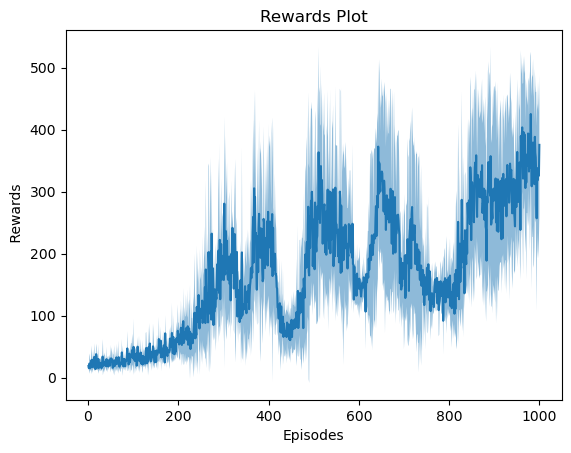

In [8]:
Regret_type1 = np.mean(np.sum(500-total_rewards,axis=1),axis=0)
print("\nRegret =", Regret_type1)
rewards_mean_type1 = np.mean(total_rewards,axis=0)
reward_std_type1 = np.std(total_rewards, axis=0)



Regret = 313723.6


In [9]:
data = np.vstack([rewards_mean_type1,reward_std_type1]).T
dff= pd.DataFrame(np.array(data),columns = ["Mean","Std"])
dff.to_csv("MC_REINFORCE_WOB_2AM.csv", index = False)

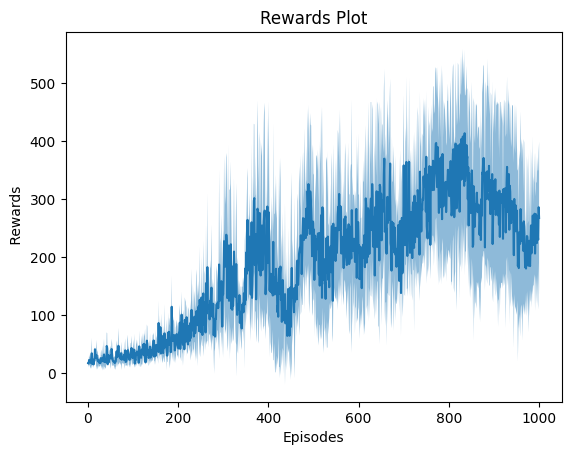

In [10]:
plt.plot(np.arange(1,len(rewards_mean_type1)+1),rewards_mean_type1)
plt.fill_between(np.arange(1,len(rewards_mean_type1)+1),rewards_mean_type1 - reward_std_type1,rewards_mean_type1 + reward_std_type1, alpha=0.5)
plt.xlabel("Episodes")
plt.ylabel(" Rewards")
plt.title("Rewards Plot")
plt.show()

# Final Draft

In [ ]:
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
num_exp = 5
max_episodes = 1000
total_rewards = np.zeros([num_exp,max_episodes])
for i in range(num_exp):
    state_shape = env.observation_space.shape[0]
    action_shape = env.action_space.n
    policy = Policy(state_size=state_shape, action_size=action_shape, seed=i, num_policy_layers =2,num_policy_layer_units= 128).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=1e-4)
    scores = reinforce(policy, optimizer, n_episodes=max_episodes)
    total_rewards[i] = scores
Regret = np.mean(np.sum(500-total_rewards,axis=1),axis=0)

Episode 0	Average Score: 14.00
Episode 100	Average Score: 27.69
Episode 200	Average Score: 31.78
Episode 300	Average Score: 37.01
Episode 400	Average Score: 49.36
Episode 500	Average Score: 79.70
Episode 600	Average Score: 134.56
Episode 700	Average Score: 165.60
Episode 800	Average Score: 199.40
Episode 900	Average Score: 246.14


{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'avg_regret'},
 'parameters': {'act_algorithm': {'values': ['softmax', 'epsilon']},
                'batch_size': {'values': [32, 64, 128]},
                'buffer_size': {'values': [100, 1000, 10000, 100000]},
                'epsilon_tau_decay': {'values': [0.995, 0.95, 0.9, 0.85]},
                'epsilon_tau_start': {'values': [1, 0.5]},
                'lr': {'values': [0.01, 0.001, 0.0001]},
                'num_common_layer_units': {'values': [128, 256, 512]},
                'num_common_layers': {'values': [1, 2, 3]},
                'type': {'values': [1]},
                'update_every': {'values': [10, 20, 30]}}}
Create sweep with ID: 29klzxlf
Sweep URL: https://wandb.ai/nayinisriharsh-iitm/CS6700_PROGRAMMING_ASSIGNMENT_2/sweeps/4v1fcu0q